<a href="https://colab.research.google.com/github/GrueneKatze/AI-for-Medicine-Coursera/blob/master/keras_bikes_LSTM_28_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NN: bike rent prediction with keras

Here I'm trying to predict hourly bike rental ridership. 

In [ ]:

import seaborn as sns

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras import metrics

from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [ ]:

from sklearn.preprocessing import MinMaxScaler

In [ ]:
data_path = r'C:\Users\Tanya\bike_hour_dataset.csv'# 
rides = pd.read_csv(data_path)
rides.head()


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


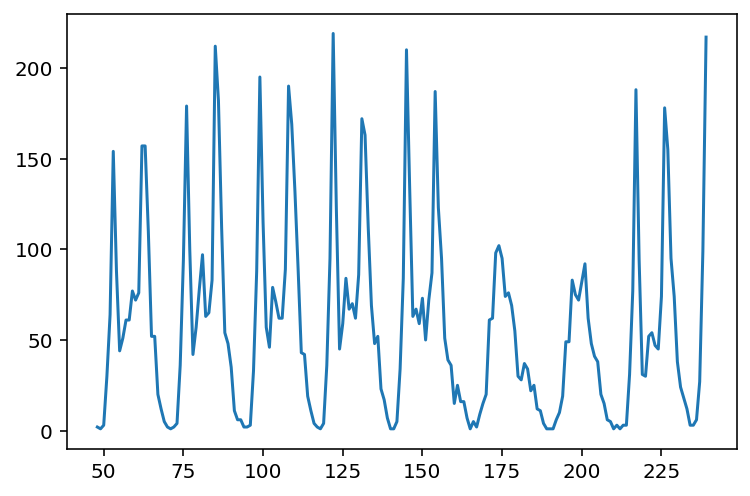

In [ ]:
plt.plot(rides['cnt'][48:240])


In [ ]:
fields_to_drop = ['casual', 'registered']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [ ]:
data.shape

(17379, 15)

In [ ]:
corrmat = data.corr()

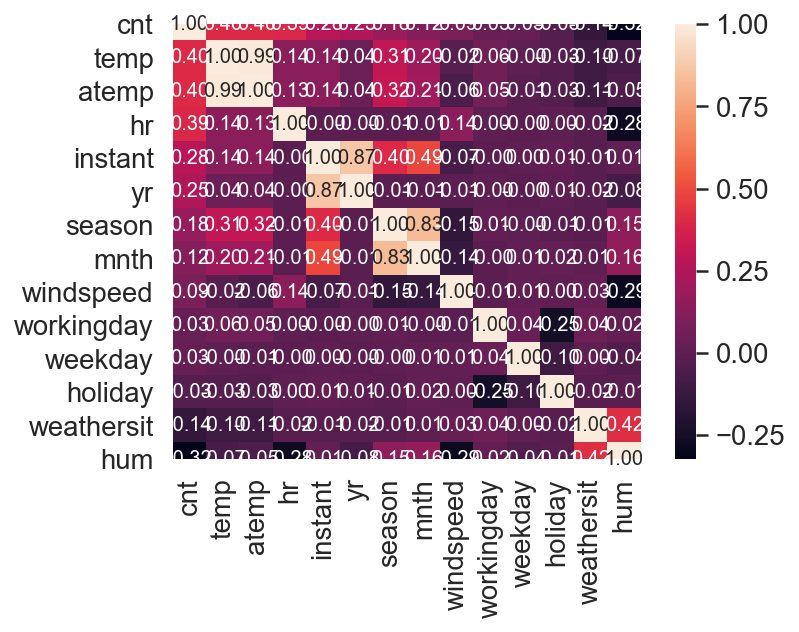

In [ ]:
cols = ['instant','dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'cnt')['cnt'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Initial preprocessing  

In [ ]:
#skip to avoid using date as index
data.set_index('dteday', inplace=True)
data

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
dteday,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16
2011-01-01,2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40
2011-01-01,3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32
2011-01-01,4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13
2011-01-01,5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31,17375,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,119
2012-12-31,17376,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,89
2012-12-31,17377,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,90


In [ ]:
#exclude 'dteday' if using date as index
fields_to_drop = ['atemp', 'mnth', 'instant', 'weekday']# ['atemp', 'mnth', 'dteday', 'instant', 'weekday']#
data_wo_corrs = data.drop(fields_to_drop, axis=1)
data_wo_corrs.head()

,season,yr,hr,holiday,workingday,weathersit,temp,hum,windspeed,cnt
dteday,,,,,,,,,,
2011-01-01,1,0,0,0,0,1,0.24,0.81,0.0,16
2011-01-01,1,0,1,0,0,1,0.22,0.80,0.0,40
2011-01-01,1,0,2,0,0,1,0.22,0.80,0.0,32
2011-01-01,1,0,3,0,0,1,0.24,0.75,0.0,13
2011-01-01,1,0,4,0,0,1,0.24,0.75,0.0,1


In [ ]:
dummy_fields = ['season', 'weathersit', 'hr', 'workingday', 'holiday']#['season', 'hr','weathersit', 'mnth', 'workingday', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(data_wo_corrs[each], prefix=each, drop_first=False)
    data_wo_corrs = pd.concat([dummies, data_wo_corrs], axis=1)

#rides.head() 
fields_to_drop = ['season', 'weathersit', 'hr', 'workingday', 'holiday']
#fields_to_drop = ['instant', 'dteday','casual', 'registered', 'season', 'weathersit', 
 #                 'weekday', 'atemp', 'mnth', 'workingday', 'hr']#'ve adeed 'casual', 'registered'
data_w_dummies = data_wo_corrs.drop(fields_to_drop, axis=1)
data_w_dummies.head()

,holiday_0,holiday_1,workingday_0,workingday_1,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,...,weathersit_4,season_1,season_2,season_3,season_4,yr,temp,hum,windspeed,cnt
dteday,,,,,,,,,,,,,,,,,,,,,
2011-01-01,1,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0.24,0.81,0.0,16
2011-01-01,1,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0.22,0.80,0.0,40
2011-01-01,1,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0.22,0.80,0.0,32
2011-01-01,1,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0.24,0.75,0.0,13
2011-01-01,1,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0.24,0.75,0.0,1


## Version 0. Simple sequential

In [ ]:
targets = data_w_dummies['cnt'].values

In [ ]:
fields_to_drop = ['cnt']
X_train = data_w_dummies.drop(fields_to_drop, axis=1)
X_train.head()

,holiday_0,holiday_1,workingday_0,workingday_1,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,...,weathersit_3,weathersit_4,season_1,season_2,season_3,season_4,yr,temp,hum,windspeed
0,1,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0.24,0.81,0.0
1,1,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0.22,0.80,0.0
2,1,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0.22,0.80,0.0
3,1,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0.24,0.75,0.0
4,1,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0.24,0.75,0.0


## Splitting to train, test and val, scaling and reshaping

In [ ]:
X_train, X_t, y_train, y_t = train_test_split(X_train, targets, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_t, y_t, test_size = 0.5)

In [ ]:
print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)

print('X_test.shape', X_test.shape)
print('y_test.shape', y_test.shape)

print('X_val.shape', X_val.shape)
print('y_val.shape', y_val.shape)

X_train.shape (12165, 40)
y_train.shape (12165,)
X_test.shape (2607, 40)
y_test.shape (2607,)
X_val.shape (2607, 40)
y_val.shape (2607,)


In [ ]:
#scal = StandardScaler()
scal = MinMaxScaler()
X_train = scal.fit_transform(X_train)


In [ ]:
scaly = MinMaxScaler()
X_test = scal.transform(X_test)
X_val = scal.transform(X_val)
y_train= scaly.fit_transform(y_train.reshape(-1, 1))#[:,np.newaxis])#.reshape(-1, 1))##fit_transform(y_train[:,np.newaxis])#.reshape(-1, 1))#
y_test= scaly.transform(y_test.reshape(-1, 1))#[:,np.newaxis])#.reshape(-1, 1))#[:,np.newaxis])
y_val= scaly.transform(y_val.reshape(-1, 1))#[:,np.newaxis])#.reshape(-1, 1))#[:,np.newaxis])

In [ ]:
print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)

print('X_test.shape', X_test.shape)
print('y_test.shape', y_test.shape)

print('X_val.shape', X_val.shape)
print('y_val.shape', y_val.shape)


X_train.shape (12165, 40)
y_train.shape (12165, 1)
X_test.shape (2607, 40)
y_test.shape (2607, 1)
X_val.shape (2607, 40)
y_val.shape (2607, 1)


## Creating sequential model

In [ ]:

#V.4 with scaling y-s 
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=40, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(40, activation='relu'))
    #model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer ='adamax', loss = 'mean_squared_error', metrics =[metrics.mae, 'accuracy'])#, metrics.accuracy(y_test, y_pred)])
    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                410       
_________________________________________________________________
dense_6 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_7 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 41        
Total params: 2,021
Trainable params: 2,021
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=32)

Train on 12165 samples, validate on 2607 samples
Epoch 1/100
12165/12165 [==============================] - 3s 281us/step - loss: 0.0238 - mean_absolute_error: 0.1154 - acc: 0.0088 - val_loss: 0.0144 - val_mean_absolute_error: 0.0874 - val_acc: 0.0096
Epoch 2/100
12165/12165 [==============================] - 2s 191us/step - loss: 0.0097 - mean_absolute_error: 0.0717 - acc: 0.0089 - val_loss: 0.0079 - val_mean_absolute_error: 0.0627 - val_acc: 0.0096
Epoch 3/100
12165/12165 [==============================] - 2s 197us/step - loss: 0.0064 - mean_absolute_error: 0.0566 - acc: 0.0089 - val_loss: 0.0058 - val_mean_absolute_error: 0.0538 - val_acc: 0.0096
Epoch 4/100
12165/12165 [==============================] - 2s 183us/step - loss: 0.0051 - mean_absolute_error: 0.0499 - acc: 0.0089 - val_loss: 0.0048 - val_mean_absolute_error: 0.0486 - val_acc: 0.0096
Epoch 5/100
12165/12165 [==============================] - 2s 186us/step - loss: 0.0044 - mean_absolute_error: 0.0460 - acc: 0.0089 - val_l

12165/12165 [==============================] - 2s 195us/step - loss: 0.0023 - mean_absolute_error: 0.0316 - acc: 0.0089 - val_loss: 0.0029 - val_mean_absolute_error: 0.0345 - val_acc: 0.0096
Epoch 81/100
12165/12165 [==============================] - 3s 275us/step - loss: 0.0023 - mean_absolute_error: 0.0312 - acc: 0.0089 - val_loss: 0.0027 - val_mean_absolute_error: 0.0323 - val_acc: 0.0096
Epoch 82/100
12165/12165 [==============================] - 3s 213us/step - loss: 0.0023 - mean_absolute_error: 0.0312 - acc: 0.0089 - val_loss: 0.0028 - val_mean_absolute_error: 0.0335 - val_acc: 0.0096
Epoch 83/100
12165/12165 [==============================] - 2s 205us/step - loss: 0.0023 - mean_absolute_error: 0.0315 - acc: 0.0089 - val_loss: 0.0027 - val_mean_absolute_error: 0.0328 - val_acc: 0.0096
Epoch 84/100
12165/12165 [==============================] - 2s 171us/step - loss: 0.0023 - mean_absolute_error: 0.0314 - acc: 0.0089 - val_loss: 0.0029 - val_mean_absolute_error: 0.0337 - val_acc: 

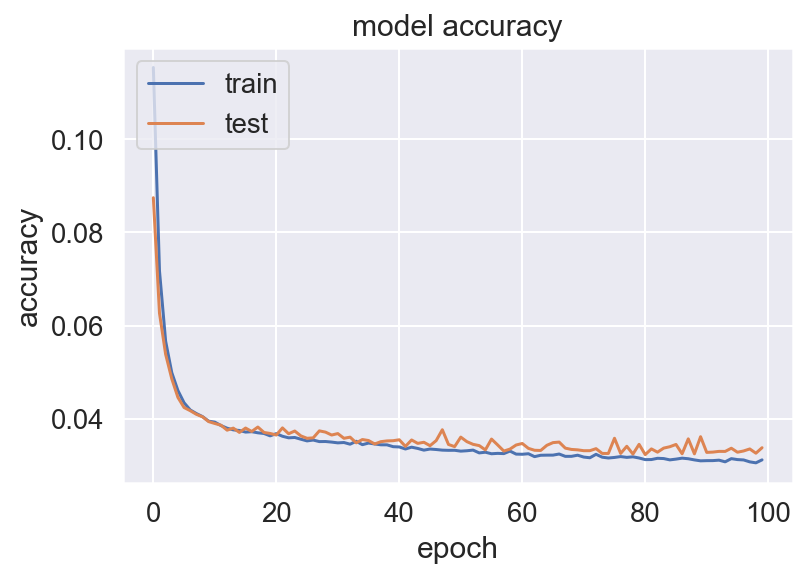

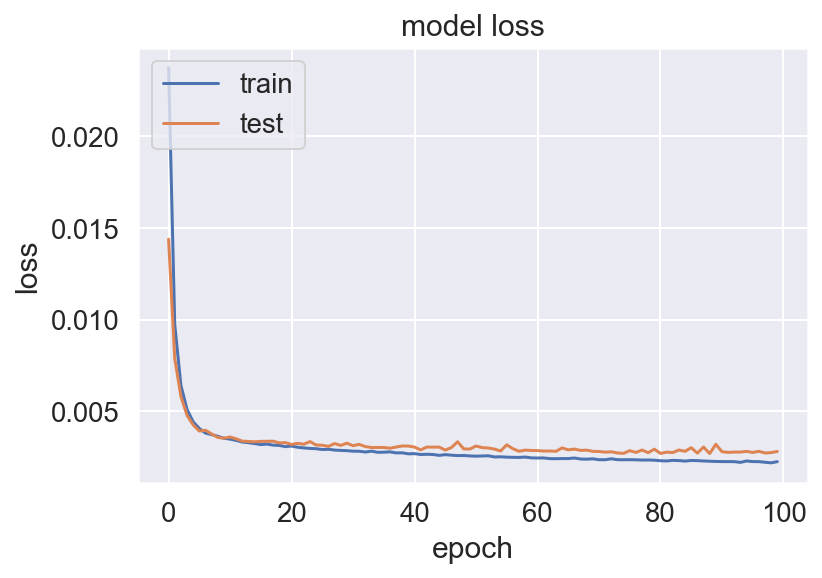

In [ ]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#with accuracy added as metric
scores = model.evaluate(X_val,y_val)
print([s*100 for s in scores])

2607/2607 [==============================] - 0s 82us/step
[0.27717944111987247, 3.4476590083821277, 0.9973149213655543]


In [ ]:
#prediction
predicted_values = model.predict(X_val)#, batch_size=12)
#model.reset_states()

#print(predicted_values.shape)
#inverse transform
predicted_values = scaly.inverse_transform(predicted_values)

In [ ]:
#real_values = np.reshape(y_val_res,(y_val_res.shape[0], y_val_res.shape[1]))
#print(real_values.shape)
real_values = scaly.inverse_transform(y_val)

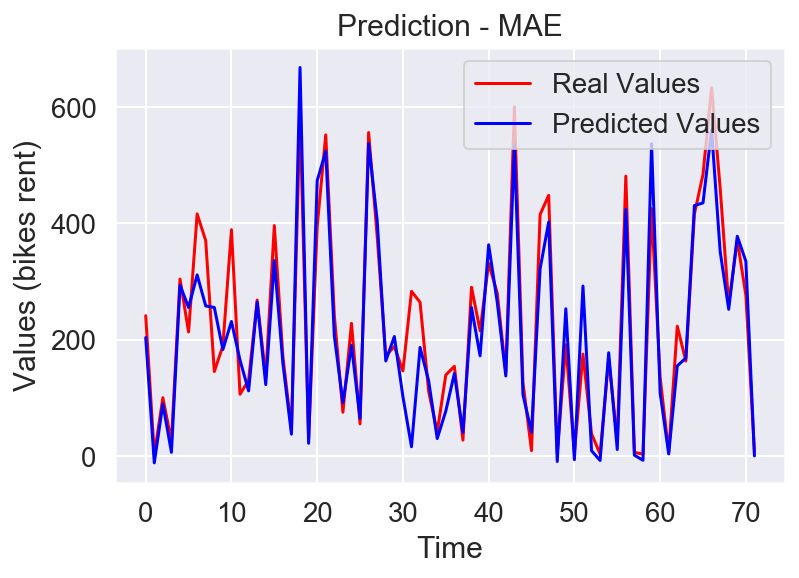

In [ ]:
# Visualising the results (adam, more LSTM layers, 12)
plt.plot(real_values[0:72].astype(float), color = 'red', label = 'Real Values')
plt.plot(predicted_values[0:72].astype(float), color = 'blue', label = 'Predicted Values')
plt.title('Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Values (bikes rent)')
plt.legend()
plt.show()

## LSTM Version 1. Dataset processing to predict values based on features

In [ ]:



targets = data_w_dummies['cnt'].values

In [ ]:
fields_to_drop = ['cnt']
X_train = data_w_dummies.drop(fields_to_drop, axis=1)
X_train.head()

,holiday_0,holiday_1,workingday_0,workingday_1,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,...,weathersit_3,weathersit_4,season_1,season_2,season_3,season_4,yr,temp,hum,windspeed
dteday,,,,,,,,,,,,,,,,,,,,,
2011-01-01,1,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0.24,0.81,0.0
2011-01-01,1,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0.22,0.80,0.0
2011-01-01,1,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0.22,0.80,0.0
2011-01-01,1,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0.24,0.75,0.0
2011-01-01,1,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0.24,0.75,0.0


## Splitting to train, test and val, scaling and reshaping for LSTM

In [ ]:
X_train, X_t, y_train, y_t = train_test_split(X_train, targets, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_t, y_t, test_size = 0.5)

In [ ]:
#scal = StandardScaler()
scal = MinMaxScaler()
X_train = scal.fit_transform(X_train)
#X_train

In [ ]:
X_train.shape

(12165, 40)

In [ ]:
#larger batches (24)
X_train_ = np.delete(X_train, slice(12096,12165), axis = 0)
X_train_.shape

(12096, 40)

In [ ]:
#larger batches (24)
X_train_res = np.reshape(X_train_, (504, -1, X_train_.shape[1]))

In [ ]:
X_train_res.shape

(504, 24, 40)

In [ ]:
#to check shape of scaled sets and remove odd slices with axis = 0, e.g. np.delete(X_train, slice(12144,12165), axis = 0)
X_test = scal.transform(X_test)
X_val = scal.transform(X_val)

In [ ]:
#larger batches 

X_test_ = np.delete(X_test, slice(2304,2607), axis = 0)
X_val_ = np.delete(X_val, slice(2304,2607), axis = 0)


In [ ]:
#larger batches (24)
X_test_res = np.reshape(X_test_, (96, -1, X_test_.shape[1]))#, X_train.shape[1], 1))
X_val_res = np.reshape(X_val_, (96, -1, X_val_.shape[1]))

In [ ]:
#scaly = StandardScaler()
scaly = MinMaxScaler()
y_train= scaly.fit_transform(y_train[:,np.newaxis])#.reshape(-1, 1))#
y_test= scaly.transform(y_test[:,np.newaxis])#.reshape(-1, 1))#[:,np.newaxis])
y_val= scaly.transform(y_val[:,np.newaxis])#.reshape(-1, 1))#[:,np.newaxis])

In [ ]:
# larger batches for y_train_, y_test & y_val 

y_train_ = np.delete(y_train, slice(12096,12165), axis = 0)
y_test_ = np.delete(y_test, slice(2304,2607), axis = 0)
y_val_ = np.delete(y_val, slice(2304,2607), axis =0)

In [ ]:
# larger batches for y_train_, y_test & y_val 

y_train_res = np.reshape(y_train_, (504, -1, 1))# adding 1 dimension to ys # np.reshape(y_train_, (506, -1))#, X_train_.shape[1]))
y_test_res = np.reshape(y_test_, (96, -1, 1))#np.reshape(y_test_, (108, -1))
y_val_res = np.reshape(y_val_, (96, -1, 1))


In [ ]:
print('X_train_res.shape', X_train_res.shape)
print('y_train_res.shape', y_train_res.shape)

print('X_test_res.shape', X_test_res.shape)
print('y_test_res.shape', y_test_res.shape)

print('X_val_res.shape', X_val_res.shape)
print('y_val_res.shape', y_val_res.shape)


X_train_res.shape (504, 24, 40)
y_train_res.shape (504, 24, 1)
X_test_res.shape (96, 24, 40)
y_test_res.shape (96, 24, 1)
X_val_res.shape (96, 24, 40)
y_val_res.shape (96, 24, 1)


## Creating model (with stateful = True)

In [ ]:
#V.11 with LSTM layers and stateful=True, return_sequences=True WITH batch_input_shape=(BATCH_SIZE, TIME_STEPS, X_train_res.shape[2])
def create_model():
    # create model
    model = Sequential()
    model.add(LSTM(50, batch_input_shape=(12, X_train_res.shape[1], X_train_res.shape[2]),stateful=True,return_sequences=True))
    model.add(LSTM(50,stateful=True,return_sequences=True))
    model.add(LSTM(50,stateful=True,return_sequences=True))
    model.add(LSTM(40,stateful=True,return_sequences=True))
    model.add(LSTM(20,stateful=True,return_sequences=True))
    
    
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer ='adam', loss = 'mean_squared_error', metrics =[metrics.mae])#, 'accuracy'])#, metrics.accuracy(y_test, y_pred)])
    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (12, 24, 50)              18200     
_________________________________________________________________
lstm_6 (LSTM)                (12, 24, 50)              20200     
_________________________________________________________________
lstm_7 (LSTM)                (12, 24, 50)              20200     
_________________________________________________________________
lstm_8 (LSTM)                (12, 24, 40)              14560     
_________________________________________________________________
lstm_9 (LSTM)                (12, 24, 20)              4880      
_________________________________________________________________
dense_10 (Dense)             (12, 24, 1)               21        
Total params: 78,061
Trainable params: 78,061
Non-trainable params: 0
__________________________________________________

In [ ]:
def train_model(your_model, x_t, y_t, x_v, y_v, Epochs, batches):
    for i in range(Epochs):
        print('Epoch'+ str(i))
        your_model.fit(x_t, y_t, validation_data=(x_v, y_v), shuffle=False, epochs=1, batch_size=batches)
        your_model.reset_states()
    return your_model

In [ ]:
history = train_model(model, X_train_res, y_train_res, X_test_res,y_test_res, 50, 12)

Epoch0
Train on 504 samples, validate on 96 samples
Epoch 1/1
504/504 [==============================] - 30s 60ms/step - loss: 0.0389 - mean_absolute_error: 0.1518 - val_loss: 0.0331 - val_mean_absolute_error: 0.1468
Epoch1
Train on 504 samples, validate on 96 samples
Epoch 1/1
504/504 [==============================] - 13s 27ms/step - loss: 0.0356 - mean_absolute_error: 0.1469 - val_loss: 0.0331 - val_mean_absolute_error: 0.1462
Epoch2
Train on 504 samples, validate on 96 samples
Epoch 1/1
504/504 [==============================] - 15s 30ms/step - loss: 0.0355 - mean_absolute_error: 0.1470 - val_loss: 0.0331 - val_mean_absolute_error: 0.1460
Epoch3
Train on 504 samples, validate on 96 samples
Epoch 1/1
504/504 [==============================] - 12s 24ms/step - loss: 0.0355 - mean_absolute_error: 0.1469 - val_loss: 0.0331 - val_mean_absolute_error: 0.1459
Epoch4
Train on 504 samples, validate on 96 samples
Epoch 1/1
504/504 [==============================] - 11s 21ms/step - loss: 0.035

In [ ]:
scores = model.evaluate(X_val_res,y_val_res, batch_size = 12)
print([s*100 for s in scores])

96/96 [==============================] - 1s 10ms/step
[0.46560196788050234, 4.354229662567377]


In [ ]:
#prediction
predicted_values = model.predict(X_val_res, batch_size=12)
model.reset_states()

print(predicted_values.shape)

#reshaping
predicted_values = np.reshape(predicted_values, 
                                       (predicted_values.shape[0], 
                                        predicted_values.shape[1]))

print(predicted_values.shape)
#inverse transform
predicted_values = scaly.inverse_transform(predicted_values)

(96, 24, 1)
(96, 24)


In [ ]:
real_values = np.reshape(y_val_res,(y_val_res.shape[0], y_val_res.shape[1]))
#print(real_values.shape)
real_values = scaly.inverse_transform(real_values)

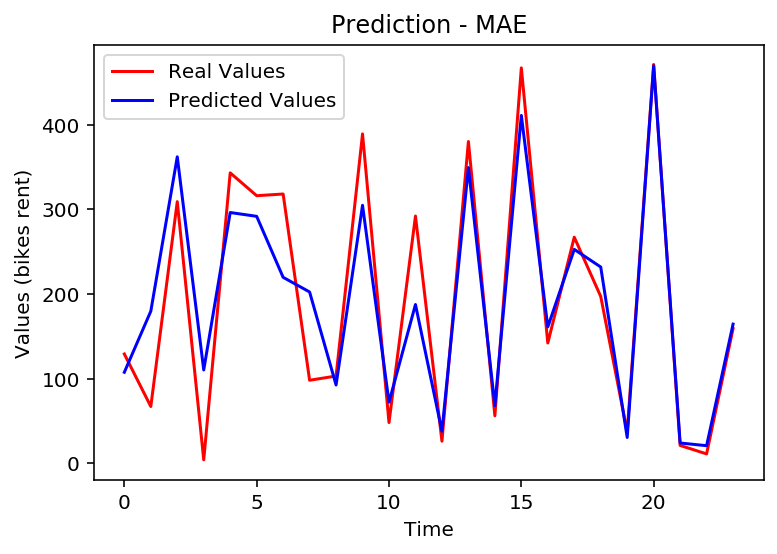

In [ ]:
# Visualising the results (adam, more LSTM layers, 12)
plt.plot(real_values[3].astype(float), color = 'red', label = 'Real Values')
plt.plot(predicted_values[3].astype(float), color = 'blue', label = 'Predicted Values')
plt.title('Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Values (bikes rent)')
plt.legend()
plt.show()

In [ ]:
#X_val_res.shape
val_features = np.reshape(X_val_res,(X_val_res.shape[0], X_val_res.shape[1]*X_val_res.shape[2]))
#print(real_values.shape)
val_features = scaly.inverse_transform(val_features)

In [ ]:
val_features[2]

array([977.        ,   1.        ,   1.        , 977.        ,
         1.        , 977.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
       977.        ,   1.        ,   1.        ,   1.        ,
       977.        ,   1.        ,   1.        ,   1.        ,
       977.        , 184.        , 430.44      , 292.0675914 ,
       977.        ,   1.        , 977.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        , 977.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.  

In [ ]:
from keras.models import model_from_json

In [ ]:
#https://machinelearningmastery.com/save-load-keras-deep-learning-models/
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
#loaded_model.compile(

## Version 2. Predicting values based on previous values 


In [ ]:
rides.set_index('dteday', inplace=True)
rides.head()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2011-01-01,2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2011-01-01,3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
2011-01-01,4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
2011-01-01,5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [ ]:
data = rides['cnt'].values
data= data[0:17376]
#data.shape

In [ ]:


Xs, Ys = [], []
step = 24
for i in range(step, len(data)-step*2): #(len(Xs)-step*2):
    Xs.append(data[i:step+i])
    Ys.append(data[step+i:step*2+i])
    #try smaller ys (e.g. 2-4 values)
    #Ys.append(data[step+i:step+3+i])
    #getting ValueError: Error when checking target: expected dense_3 to have shape (24, 3) but got array with shape (3, 1)
print(len(Xs))
print(len(Ys)) 

17304
17304


In [ ]:
Xs = np.array(Xs)
Ys = np.array(Ys)

In [ ]:
X_train, X_t, y_train, y_t = train_test_split(Xs, Ys, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_t, y_t, test_size = 0.5)

In [ ]:
#scal = StandardScaler()
scal = MinMaxScaler()
X_train = scal.fit_transform(X_train)

#X_train

In [ ]:
X_test = scal.transform(X_test)
X_val = scal.transform(X_val)

scaly = MinMaxScaler()
y_train = scaly.fit_transform(y_train)
y_test = scaly.transform(y_test)
y_val = scaly.transform(y_val)


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(12112, 24)
(12112, 24)
(2596, 24)
(2596, 24)
(2596, 24)
(2596, 24)


In [ ]:

X_train_ = np.delete(X_train, slice(12096,12112), axis = 0)
y_train = np.delete(y_train, slice(12096,12112), axis = 0)
X_test = np.delete(X_test, slice(2592,2596), axis = 0)
y_test = np.delete(y_test, slice(2592,2596), axis = 0)
X_val = np.delete(X_val, slice(2592,2596), axis = 0)
y_val = np.delete(y_val, slice(2592,2596), axis = 0)


In [ ]:
#8.12 - TRY RESHAPE X_train_res = np.reshape(X_train_, (504, -1, X_train_.shape[1]))


#larger batches (24)
X_train_res = np.reshape(X_train_, (X_train_.shape[0], X_train_.shape[1], 1))
y_train_res = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
X_test_res = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test_res = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))
X_val_res = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
y_val_res = np.reshape(y_val, (y_val.shape[0], y_val.shape[1], 1))

In [ ]:
X_train_res[0]

array([[0.03790984],
       [0.02356557],
       [0.01741803],
       [0.01127049],
       [0.00204918],
       [0.00204918],
       [0.00512821],
       [0.02663934],
       [0.10040984],
       [0.22131148],
       [0.13217213],
       [0.05430328],
       [0.03483607],
       [0.05737705],
       [0.05230769],
       [0.06352459],
       [0.04713115],
       [0.07684426],
       [0.13831967],
       [0.09631148],
       [0.05122951],
       [0.03179487],
       [0.01946721],
       [0.02871795]])

In [ ]:
print('X_train_res.shape', X_train_res.shape)
print('y_train_res.shape', y_train_res.shape)

print('X_test_res.shape', X_test_res.shape)
print('y_test_res.shape', y_test_res.shape)

print('X_val_res.shape', X_val_res.shape)
print('y_val_res.shape', y_val_res.shape)

X_train_res.shape (12096, 24, 1)
y_train_res.shape (12096, 3, 1)
X_test_res.shape (2592, 24, 1)
y_test_res.shape (2592, 3, 1)
X_val_res.shape (2592, 24, 1)
y_val_res.shape (2592, 3, 1)


In [ ]:
#too large

#V.10 with LSTM layers and stateful=True, return_sequences=True WITH batch_input_shape=(BATCH_SIZE, TIME_STEPS, X_train_res.shape[2])
def create_model():
    # create model
    model = Sequential()
    model.add(LSTM(50, batch_input_shape=(12, X_train_res.shape[1], X_train_res.shape[2]),stateful=True,return_sequences=True))
    model.add(LSTM(50,stateful=True,return_sequences=True))
    model.add(LSTM(50,stateful=True,return_sequences=True))
    model.add(LSTM(40,stateful=True,return_sequences=True))
    model.add(LSTM(20,stateful=True,return_sequences=True))
    
    
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer ='adam', loss = 'mean_squared_error', metrics =[metrics.mae])#, 'accuracy'])#, metrics.accuracy(y_test, y_pred)])
    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (12, 24, 50)              10400     
_________________________________________________________________
lstm_32 (LSTM)               (12, 24, 50)              20200     
_________________________________________________________________
lstm_33 (LSTM)               (12, 24, 50)              20200     
_________________________________________________________________
lstm_34 (LSTM)               (12, 24, 40)              14560     
_________________________________________________________________
lstm_35 (LSTM)               (12, 24, 20)              4880      
_________________________________________________________________
dense_6 (Dense)              (12, 24, 1)               21        
Total params: 70,261
Trainable params: 70,261
Non-trainable params: 0
__________________________________________________

In [ ]:
def train_model(your_model, x_t, y_t, x_v, y_v, Epochs, batches):
    for i in range(Epochs):
        print('Epoch'+ str(i))
        your_model.fit(x_t, y_t, validation_data=(x_v, y_v), shuffle=False, epochs=1, batch_size=batches)
        your_model.reset_states()
    return your_model

In [ ]:
history = train_model(model, X_train_res, y_train_res, X_test_res,y_test_res, 50, 12)

Epoch0
Train on 12096 samples, validate on 2592 samples
Epoch 1/1
 1872/12096 [===>..........................] - ETA: 50s - loss: 0.0116 - mean_absolute_error: 0.0729

KeyboardInterrupt: 

### Scores for LSTM, 5 LSTM layers, 12, adam

In [ ]:
scores = model.evaluate(X_val_res,y_val_res, batch_size = 12)
print([s*100 for s in scores])

96/96 [==============================] - 1s 7ms/step
[0.3674274717923254, 3.8977989461272955]


In [ ]:
Ys

[array([  2,   1,   3,  30,  64, 154,  88,  44,  51,  61,  61,  77,  72,
         76, 157, 157, 110,  52,  52,  20,  12,   5,   2,   1], dtype=int64),
 array([  1,   3,  30,  64, 154,  88,  44,  51,  61,  61,  77,  72,  76,
        157, 157, 110,  52,  52,  20,  12,   5,   2,   1,   2], dtype=int64),
 array([  3,  30,  64, 154,  88,  44,  51,  61,  61,  77,  72,  76, 157,
        157, 110,  52,  52,  20,  12,   5,   2,   1,   2,   4], dtype=int64),
 array([ 30,  64, 154,  88,  44,  51,  61,  61,  77,  72,  76, 157, 157,
        110,  52,  52,  20,  12,   5,   2,   1,   2,   4,  36], dtype=int64),
 array([ 64, 154,  88,  44,  51,  61,  61,  77,  72,  76, 157, 157, 110,
         52,  52,  20,  12,   5,   2,   1,   2,   4,  36,  94], dtype=int64),
 array([154,  88,  44,  51,  61,  61,  77,  72,  76, 157, 157, 110,  52,
         52,  20,  12,   5,   2,   1,   2,   4,  36,  94, 179], dtype=int64),
 array([ 88,  44,  51,  61,  61,  77,  72,  76, 157, 157, 110,  52,  52,
         20,  12,   5

In [ ]:
Xs

[array([17, 17,  9,  6,  3,  2,  1,  8, 20, 53, 70, 93, 75, 59, 74, 76, 65,
        53, 30, 22, 31,  9,  8,  5], dtype=int64),
 array([17,  9,  6,  3,  2,  1,  8, 20, 53, 70, 93, 75, 59, 74, 76, 65, 53,
        30, 22, 31,  9,  8,  5,  2], dtype=int64),
 array([ 9,  6,  3,  2,  1,  8, 20, 53, 70, 93, 75, 59, 74, 76, 65, 53, 30,
        22, 31,  9,  8,  5,  2,  1], dtype=int64),
 array([ 6,  3,  2,  1,  8, 20, 53, 70, 93, 75, 59, 74, 76, 65, 53, 30, 22,
        31,  9,  8,  5,  2,  1,  3], dtype=int64),
 array([ 3,  2,  1,  8, 20, 53, 70, 93, 75, 59, 74, 76, 65, 53, 30, 22, 31,
         9,  8,  5,  2,  1,  3, 30], dtype=int64),
 array([ 2,  1,  8, 20, 53, 70, 93, 75, 59, 74, 76, 65, 53, 30, 22, 31,  9,
         8,  5,  2,  1,  3, 30, 64], dtype=int64),
 array([  1,   8,  20,  53,  70,  93,  75,  59,  74,  76,  65,  53,  30,
         22,  31,   9,   8,   5,   2,   1,   3,  30,  64, 154], dtype=int64),
 array([  8,  20,  53,  70,  93,  75,  59,  74,  76,  65,  53,  30,  22,
         31,  

In [ ]:
#V.6 with LSTM and data reshaped by days; TRY stateful=True, return_sequences=True WITH batch_input_shape=(BATCH_SIZE, TIME_STEPS, X_train_res.shape[2])
def create_model():
    # create model
    model = Sequential()
    #model.add(LSTM(24, input_shape = (X_train_res.shape[1], 40))) #seems that input shape is wrong - should X_train_res.shape be 24, 506, 40?
    #24, 506, 40 'd be wrong, too, according to the post https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944
    # LSTMs consume input in format [ batch_size, time_steps, Features ]: 
    #Batch Size says how many samples of input do you want your Neural Net to see before updating the weights
    #Time Steps define how many units back in time you want your network to see. For example if you were working 
    #on a character prediction problem where you have a text corpus to train on and you decide 
    #to feed your network 6 characters at a time. Then your time step is 6. In our case we will be using 60 as time step 
    #i.e. we will look into 2 months of data to predict next days price. 
    model.add(LSTM(100, input_shape=(X_train_res.shape[1], X_train_res.shape[2]))) #stateful=True, return_sequences=True))
    #model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, X_train_res.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
#lstm_model.add(Dropout(0.5))
#lstm_model.add(Dense(20,activation='relu'))
#lstm_model.add(Dense(1,activation='sigmoid'))
#optimizer = optimizers.RMSprop(lr=lr)
#lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

    
    #model.add(Dense(10, input_dim=40, activation='relu'))
    model.add(Dense(50, activation='relu'))
    #
    #model.add(Dense(60, activation='relu'))
    model.add(Dense(40, activation='relu'))
    #model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer ='adamax', loss = 'mean_squared_error', metrics =[metrics.mae, 'accuracy'])#, metrics.accuracy(y_test, y_pred)])
    return model

In [ ]:
model = create_model()
model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 63,531
Trainable params: 63,531
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#V.7 with LSTM and data reshaped by days AND stateful=True
def create_model():
    # create model
    model = Sequential()
    #model.add(LSTM(24, input_shape = (X_train_res.shape[1], 40))) #seems that input shape is wrong - should X_train_res.shape be 24, 506, 40?
    #24, 506, 40 'd be wrong, too, according to the post https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944
    # LSTMs consume input in format [ batch_size, time_steps, Features ]: 
    #Batch Size says how many samples of input do you want your Neural Net to see before updating the weights
    #Time Steps define how many units back in time you want your network to see. For example if you were working 
    #on a character prediction problem where you have a text corpus to train on and you decide 
    #to feed your network 6 characters at a time. Then your time step is 6. In our case we will be using 60 as time step 
    #i.e. we will look into 2 months of data to predict next days price. 
    model.add(LSTM(100, batch_input_shape=(2, X_train_res.shape[1], X_train_res.shape[2]), stateful=True, return_sequences=True))
    #model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, X_train_res.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
#lstm_model.add(Dropout(0.5))
#lstm_model.add(Dense(20,activation='relu'))
#lstm_model.add(Dense(1,activation='sigmoid'))
#optimizer = optimizers.RMSprop(lr=lr)
#lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

    
    #model.add(Dense(10, input_dim=40, activation='relu'))
    model.add(Dense(50, activation='relu'))
    #
    model.add(Dense(60, activation='relu'))
    model.add(Dense(40, activation='relu'))
    #model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer ='adamax', loss = 'mean_squared_error', metrics =[metrics.mae, 'accuracy'])#, metrics.accuracy(y_test, y_pred)])
    return model

In [ ]:
model = create_model()
model.summary()




Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (2, 24, 100)              56400     
_________________________________________________________________
dense_1 (Dense)              (2, 24, 50)               5050      
_________________________________________________________________
dense_2 (Dense)              (2, 24, 60)               3060      
_________________________________________________________________
dense_3 (Dense)              (2, 24, 40)               2440      
_________________________________________________________________
dense_4 (Dense)              (2, 24, 1)                41        
Total params: 66,991
Trainable params: 66,991
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train_res, y_train_res, validation_data=(X_test_res,y_test_res), shuffle=False, epochs=80, batch_size=2)

Train on 506 samples, validate on 108 samples
Epoch 1/80
506/506 [==============================] - 18s 36ms/step - loss: 0.0014 - mean_absolute_error: 0.0263 - acc: 0.0096 - val_loss: 0.0041 - val_mean_absolute_error: 0.0423 - val_acc: 0.0093
Epoch 2/80
506/506 [==============================] - 24s 47ms/step - loss: 0.0012 - mean_absolute_error: 0.0251 - acc: 0.0096 - val_loss: 0.0041 - val_mean_absolute_error: 0.0419 - val_acc: 0.0093
Epoch 3/80
506/506 [==============================] - 19s 37ms/step - loss: 0.0011 - mean_absolute_error: 0.0239 - acc: 0.0096 - val_loss: 0.0041 - val_mean_absolute_error: 0.0419 - val_acc: 0.0093
Epoch 4/80
506/506 [==============================] - 15s 30ms/step - loss: 0.0010 - mean_absolute_error: 0.0233 - acc: 0.0096 - val_loss: 0.0043 - val_mean_absolute_error: 0.0424 - val_acc: 0.0093
Epoch 5/80
506/506 [==============================] - 10s 20ms/step - loss: 9.9319e-04 - mean_absolute_error: 0.0230 - acc: 0.0096 - val_loss: 0.0044 - val_mean_a

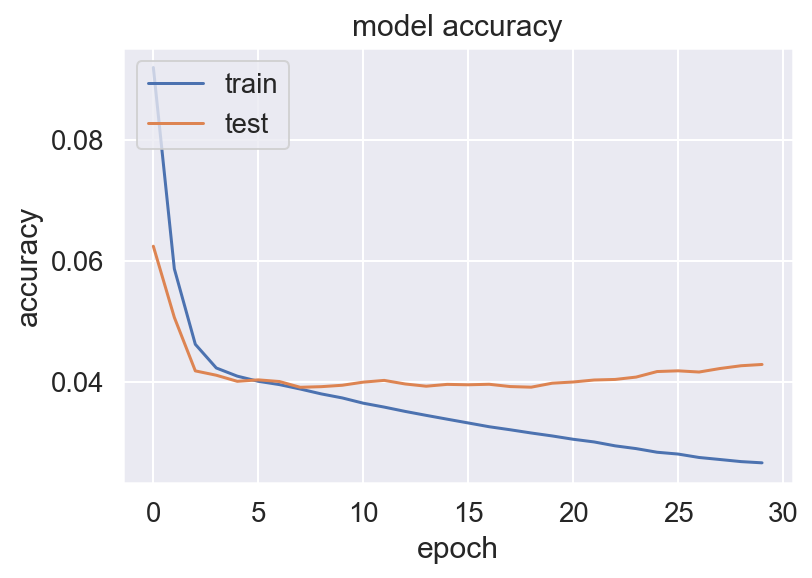

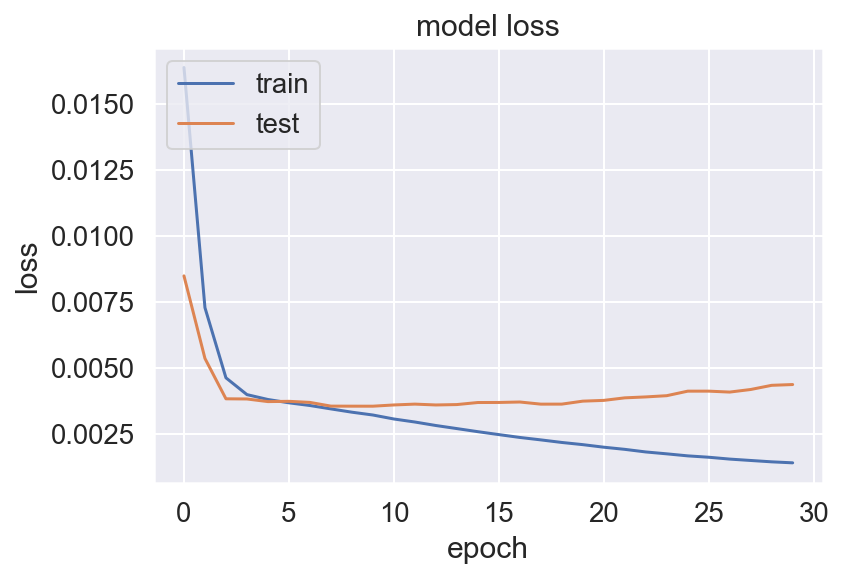

In [ ]:
#30 epochs

plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('mean_absolute_error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [ ]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == r'C:\Users\ah002\bike_dataset_hour.csv')#'bike-sharing-dataset/hour.csv')#r'C:\Users\Tanya\bike dataset_day.csv'
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

#uncomment
#suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
#unittest.TextTestRunner().run(suite)

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, this process can have sharply diminishing returns and can waste computational resources if you use too many iterations.  You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. The ideal number of iterations would be a level that stops shortly after the validation loss is no longer decreasing.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. Normally a good choice to start at is 0.1; however, if you effectively divide the learning rate by n_records, try starting out with a learning rate of 1. In either case, if the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
In a model where all the weights are optimized, the more hidden nodes you have, the more accurate the predictions of the model will be.  (A fully optimized model could have weights of zero, after all.) However, the more hidden nodes you have, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.  

Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.  You'll generally find that the best number of hidden nodes to use ends up being between the number of input and output nodes.

In [ ]:
import sys

####################
### Set the hyperparameters in you myanswers.py file ###
####################

#from my_answers import iterations, learning_rate, hidden_nodes, output_nodes

#Hyperparameters
iterations = 6000
learning_rate = 0.75
hidden_nodes = 50
output_nodes = 1


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

In [ ]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

In [ ]:
#v.1 NOT USE

class NeuralNetwork(object):
    
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        # self.activation_function = sigmoid  # Replace 0 with your sigmoid calculation.
        
        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        #def sigmoid(x):
         #   return 1 / (1 + np.exp(-x))   # Replace 0 with your sigmoid calculation here
        self.activation_function = sigmoid
        
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            
            #V.1
            final_outputs, hidden_outputs = self.forward_pass_train(X)  # Implement the forward pass function below
            # Implement the backproagation function below
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, 
                                                                        delta_weights_i_h, delta_weights_h_o)
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)
    
    def forward_pass_train(self, X):
        hidden_inputs = np.dot(X, self.weights_input_to_hidden)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs
        return final_outputs, hidden_outputs
    
    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        error = y - final_outputs
        error_term = error*1.0
        #output_error_term = error
        hidden_error = np.dot(self.weights_hidden_to_output, error) #(error_term, self.weights_hidden_to_output.T)#self.delta_weights_h_o.T)
        hidden_error_term = hidden_error * hidden_outputs * (1- hidden_outputs)
        #Finding deltas for weights to update them
        delta_weights_i_h += hidden_error_term * X[:,None]
        delta_weights_h_o += error_term * hidden_outputs[:,None]
        return delta_weights_i_h, delta_weights_h_o
    
    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        self.weights_hidden_to_output = self.lr*delta_weights_h_o/n_records
        self.weights_input_to_hidden = self.lr*delta_weights_i_h/n_records
         
    def run(self, features):
                
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features,self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs        
    

    
#Hyperparameters
iterations = 1000
learning_rate = 0.7
hidden_nodes = 15
output_nodes = 1


#############
# In the my_answers.py file, fill out the TODO sections as specified
#############

#from my_answers import NeuralNetwork
#v.2 

class NeuralNetwork(object):
    
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        # self.activation_function = sigmoid  # Replace 0 with your sigmoid calculation.
        
        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        #def sigmoid(x):
         #   return 1 / (1 + np.exp(-x))   # Replace 0 with your sigmoid calculation here
        self.activation_function = sigmoid
                    

    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            
            #V.1
            #final_outputs, hidden_outputs = self.forward_pass_train(X)  # Implement the forward pass function below
            # Implement the backproagation function below
            #delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, 
            #                                                            delta_weights_i_h, delta_weights_h_o)
            #self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)
            
            #v.2 Forward
            hidden_inputs = np.dot(X,self.weights_input_to_hidden)
            hidden_outputs = self.activation_function(hidden_inputs)
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs#(final_inputs)
            #Backward
            error = y - final_outputs
            error_term = error*1.0
            #output_error_term = error
            hidden_error = np.dot(self.weights_hidden_to_output, error) #(error_term, self.weights_hidden_to_output.T)#self.delta_weights_h_o.T)
            hidden_error_term = hidden_error * hidden_outputs * (1- hidden_outputs)
            #Finding deltas for weights to update them
            delta_weights_i_h += hidden_error_term * X[:,None]
            delta_weights_h_o += error_term * hidden_outputs[:,None] 
            
        #Update weights
        self.weights_hidden_to_output = self.lr*delta_weights_h_o/n_records
        self.weights_input_to_hidden = self.lr*delta_weights_i_h/n_records
    
    def run(self, features):
                
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features,self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs   
            